## Load and Preprocessing Data

In [ ]:
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torchvision import transforms

import wandb
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.models as models

from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
ds = load_dataset("garythung/trashnet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5054
    })
})


class distribution: {0: 806, 1: 1002, 2: 820, 3: 1188, 4: 964, 5: 274}


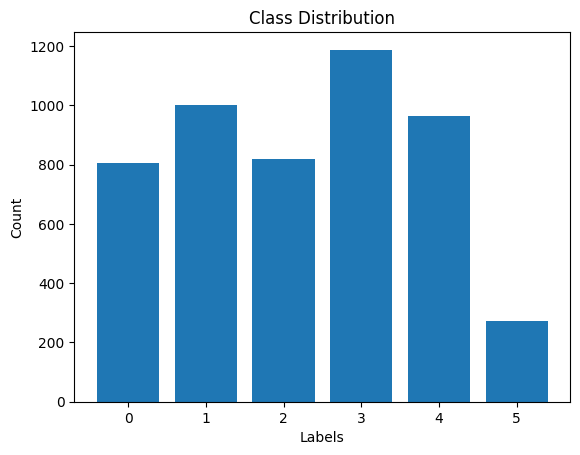

In [ ]:
labels = ds['train']['label']
unique_labels, counts = np.unique(labels, return_counts=True)
class_distribution = dict(zip(unique_labels, counts))
print("\nclass distribution:", class_distribution)

plt.bar(unique_labels, counts)
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

In [ ]:
total_samples = len(ds['train'])
num_classes = len(unique_labels)

print("\nTotal samples:", total_samples)
print("Number of classes:", num_classes)


Total samples: 5054
Number of classes: 6


In [ ]:
unique_sizes = set()
total_images = len(ds['train'])

for i in range(0, total_images, 100):
    img = ds['train'][i]['image']
    unique_sizes.add(img.size)
    if i % 100 == 0:
        print(f"Processed {i}/{total_images} images")

print("\nunique sizes of image:", list(unique_sizes))

Processed 0/5054 images
Processed 100/5054 images
Processed 200/5054 images
Processed 300/5054 images
Processed 400/5054 images
Processed 500/5054 images
Processed 600/5054 images
Processed 700/5054 images
Processed 800/5054 images
Processed 900/5054 images
Processed 1000/5054 images
Processed 1100/5054 images
Processed 1200/5054 images
Processed 1300/5054 images
Processed 1400/5054 images
Processed 1500/5054 images
Processed 1600/5054 images
Processed 1700/5054 images
Processed 1800/5054 images
Processed 1900/5054 images
Processed 2000/5054 images
Processed 2100/5054 images
Processed 2200/5054 images
Processed 2300/5054 images
Processed 2400/5054 images
Processed 2500/5054 images
Processed 2600/5054 images
Processed 2700/5054 images
Processed 2800/5054 images
Processed 2900/5054 images
Processed 3000/5054 images
Processed 3100/5054 images
Processed 3200/5054 images
Processed 3300/5054 images
Processed 3400/5054 images
Processed 3500/5054 images
Processed 3600/5054 images
Processed 370

Handling Image Sizes:
Handling a variety of image sizes involves transforming all images into uniform dimensions, in this case,
224
×
224
. This reduces computational memory and time. However, on the downside, it may lead to a significant loss of information from the images (especially those larger than 1000 pixels). Therefore, having ample computational resources would be beneficial for processing larger datasets, which could better represent real-world scenarios.

Handling Imbalanced Data:
To address the issue of imbalanced data, particularly for class number '5,' we apply a weighting strategy in the CrossEntropyLoss function. The weights are calculated inversely proportional to the class frequencies, ensuring that the model assigns greater importance to the minority class during training

Real-World Applicability:
Although the primary goal is to achieve high accuracy for this dataset, this approach may still have limitations when applied to real-world scenarios. Real-world cases often require a more diverse and extensive dataset to develop a model that achieves higher accuracy and robustness.

### Split Dataset into Training and Validation

Since, the number of dataset is not too large to train, that's why the dataset splitted only into 2 set

In [ ]:
ds_index = list(range(len(ds['train'])))
train_index, val_index = train_test_split(
    ds_index, test_size=0.2, random_state=42, stratify=ds['train']['label'])

train_dataset = Subset(ds['train'], train_index)
val_dataset = Subset(ds['train'], val_index)
print("train size:", len(train_dataset))
print("validation size:", len(val_dataset))

train size: 4043
validation size: 1011


### Preprocessing Train and Validation Data

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
from torch.utils.data import Dataset
class SimpleTrashDataset(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image = self.dataset[self.indices[idx]]['image']
        label = self.dataset[self.indices[idx]]['label']
        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = SimpleTrashDataset(ds['train'], train_index, train_transform)
val_dataset = SimpleTrashDataset(ds['train'], val_index, val_transform)


In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

for images, labels in train_loader:
    print(f"Batch size: {images.size(0)}")
    break

Batch size: 16


## Setup the Model

Since this notebook will runned on GitHub Action, the chosen model is not too large because it will use CPU system

In [ ]:
num_classes = 6
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in model.fc.parameters():
    param.requires_grad = False

for layer in [model.layer4]:
    for param in layer.parameters():
        param.requires_grad = True

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]


This is how imbalance class distribution looks like in a batch

In [ ]:
for images, labels in train_loader:
    label_counts = Counter(labels.tolist())
    print(f"Batch class distribution: {label_counts}")
    break

Batch class distribution: Counter({1: 7, 4: 2, 0: 2, 3: 2, 2: 2, 5: 1})


Apply the inverse method in CrossEntropyLoss to adjust weight of underrepresented class.This weighting strategy ensures that the minority class (class number '5' in this case) contributes proportionally more to the loss function, effectively addressing the imbalance and encouraging the model to pay more attention to underrepresented classes.

In [ ]:
train_labels = ds['train'].select(train_index)['label']

class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32)
print(f"Class Weights: {class_weights}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
class_weights = class_weights.to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

Class Weights: tensor([0.8278, 0.6657, 0.8139, 0.5620, 0.6925, 2.4380])


In [ ]:
print(f"Model device: {next(model.parameters()).device}")
print(f"Class weights device: {class_weights.device}")

Model device: cuda:0
Class weights device: cuda:0


In [ ]:
wandb.login()

wandb: Currently logged in as: aulias (aulias-). Use `wandb login --relogin` to force relogin


True

### Setup W&B Hyperparameter Configuration

In [ ]:
configs = {
        "learning_rate": 0.0001,
        "optimizer": "adam",
        "dropout_rate": 0.4,
        "epochs": 15,
        "num_classes":6}

if configs["optimizer"] == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=configs["learning_rate"])
elif configs["optimizer"] == 'sgd':
    optimizer = optim.SGD(
        model.parameters(),
        lr=configs["learning_rate"],)

In [ ]:
wandb.init(
    project="trash-image-classification",
    name=f"run_resnet18_",
    config=configs,
    notes="Training ResNet with class weights"
)

### Training

In [ ]:
best_acc = 0.0
for epoch in range(configs["epochs"]):
        print(f'\nEpoch {epoch+1}/{configs["epochs"]}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        epoch_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate both running and epoch loss
            running_loss += loss.item()
            epoch_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            if batch_idx % 20 == 19:
                avg_loss = running_loss / 20
                train_accuracy = 100 * correct_train / total_train
                print(f'Batch {batch_idx+1}, Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
                wandb.log({
                    "batch_loss": avg_loss,
                    "epoch": epoch,
                    "batch": batch_idx,
                    "batch_accuracy": train_accuracy
                })
                running_loss = 0.0

        epoch_loss = epoch_loss / len(train_loader)
        epoch_accuracy = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        class_correct = {i: 0 for i in range(configs["num_classes"])}
        class_total = {i: 0 for i in range(configs["num_classes"])}

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                for label, pred in zip(labels, predicted):
                    if label == pred:
                        class_correct[label.item()] += 1
                    class_total[label.item()] += 1

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        class_accuracies = {
            f"class_{i}": 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
            for i in range(configs["num_classes"])
        }

        print(f'\nEpoch Summary:')
        print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        for class_idx, acc in class_accuracies.items():
            print(f"{class_idx}: {acc:.2f}%")

        wandb.log({
            "epoch": epoch,
            "train_loss": epoch_loss,
            "train_accuracy": epoch_accuracy,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy,
            **{f"class_{k}_accuracy": v for k, v in class_accuracies.items()}
        })

        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': val_accuracy
            }, 'best_model.pth')
            if wandb.run:
                wandb.save('best_model.pth')
            print(f"\nCheckpoint saved: 'best_model.pth'")


Epoch 1/1
----------
Batch 20, Loss: 1.6072, Accuracy: 44.38%
Batch 40, Loss: 1.2667, Accuracy: 51.72%
Batch 60, Loss: 1.0483, Accuracy: 56.56%
Batch 80, Loss: 0.8558, Accuracy: 59.30%
Batch 100, Loss: 0.7025, Accuracy: 62.75%
Batch 120, Loss: 0.6752, Accuracy: 65.52%
Batch 140, Loss: 0.6470, Accuracy: 67.01%
Batch 160, Loss: 0.5565, Accuracy: 69.26%
Batch 180, Loss: 0.5872, Accuracy: 70.45%
Batch 200, Loss: 0.4151, Accuracy: 72.22%
Batch 220, Loss: 0.5070, Accuracy: 72.93%
Batch 240, Loss: 0.5713, Accuracy: 73.67%

Epoch Summary:
Training Loss: 0.7716, Training Accuracy: 74.28%
Validation Loss: 0.3025, Validation Accuracy: 90.90%
class_0: 91.30%
class_1: 84.50%
class_2: 95.73%
class_3: 94.12%
class_4: 89.64%
class_5: 89.09%

Checkpoint saved: 'best_model.pth'


In [ ]:
wandb.finish()

### Evaluation

In [ ]:
checkpoint = torch.load('/content/best_model.pth', map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])

<ipython-input-27-b1ff9438691e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/best_model.pth', map_location='cpu')


<All keys matched successfully>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_preds = []
all_labels = []
test_correct = 0
test_total = 0

with torch.no_grad():
    model.eval()
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 90.90%


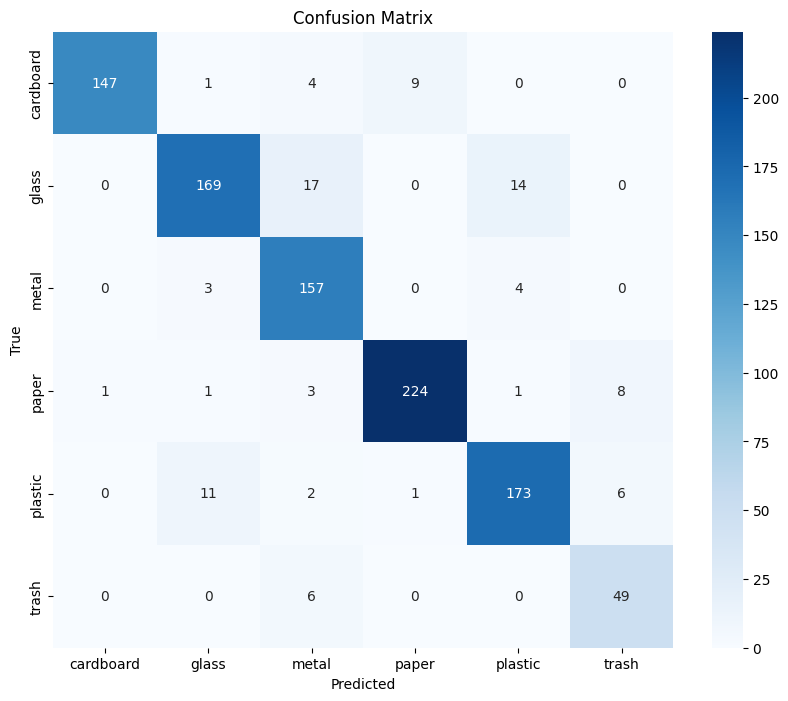

In [ ]:
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

   cardboard       0.99      0.91      0.95       161
       glass       0.91      0.84      0.88       200
       metal       0.83      0.96      0.89       164
       paper       0.96      0.94      0.95       238
     plastic       0.90      0.90      0.90       193
       trash       0.78      0.89      0.83        55

    accuracy                           0.91      1011
   macro avg       0.90      0.91      0.90      1011
weighted avg       0.91      0.91      0.91      1011

